In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error


#skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tune_sklearn import TuneSearchCV

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

#sklearn
from sklearn.model_selection import GroupKFold

In [43]:
%%time
df_training,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True) #false on AWS/colab

low memory activated
Memory usage after optimization is: 309.15 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 307.2+ MB
None
CPU times: user 44.7 s, sys: 42.8 s, total: 1min 27s
Wall time: 1min 35s


In [4]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="validation", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 65.86 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 65.4+ MB
None
CPU times: user 7.01 s, sys: 3.15 s, total: 10.2 s
Wall time: 11.3 s


### 2a Parte: Pycaret Linear Models

In [6]:
load_table = pd.read_excel("../../reports/pycaret_compare_results.xlsx", index=True)
load_table

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Orthogonal Matching Pursuit,0.3012,0.1244,0.3527,0.0015,0.2461,0.4623,1.3055
1,Bayesian Ridge,0.3009,0.1244,0.3527,0.0019,0.2461,0.4616,37.0157
2,Ridge Regression,0.3017,0.1245,0.3528,0.0013,0.2461,0.4637,6.7043
3,Linear Regression,0.3017,0.1245,0.3528,0.0013,0.2461,0.4637,6.2805
4,Automatic Relevance Determination,0.3008,0.1245,0.3529,0.0009,0.2462,0.4607,14.4360
5,Lasso Regression,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,2.7285
6,Elastic Net,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,2.0007
7,Least Angle Regression,0.3022,0.1246,0.3530,-0.0002,0.2463,0.4649,1.4324
8,Lasso Least Angle Regression,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,1.4809


### 3a Treinamento modelos

Vamos treinar os modelos
- LinearRegression
- Ridge
- Orthogonal Matching Pursuit
- Xgbost
- LightGBM
- Xgboost Ranker
- Xgboost Adj_Sharpe


In [7]:
#checando versoes para evitar conflitos
import xgboost as xgb
print("xgb version:", xgb.__version__)

import lightgbm as lgbm
print("lgbm version:", lgbm.__version__)

xgb version: 1.2.0
lgbm version: 2.3.1


#### Validacao

In [44]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

#### Metrica

In [64]:
def spearmanr(target, pred):
    from scipy import stats
    return stats.spearmanr(target, pred)[0]


scorer = make_scorer(spearmanr)

#### resultados

In [60]:
results, res_cv = list(), dict()

#### Linear regression

In [62]:
from sklearn.linear_model import LinearRegression

lr_param_grid =  {
    'fit_intercept' : [False],#[True, False],
    'normalize' : [True],#[True, False],

}


result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp, 
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for lr model, 501808 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


==> Elapsed seconds: 101.222
Best lr model: LinearRegression(fit_intercept=False, normalize=True)
Best lr score (val): 0.026


#### Ridge

In [27]:
from sklearn.linear_model import Ridge

ridge_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'alpha' : [1.5]#Real(10**-1, 10**1, "log-uniform") #[1.5]

}

result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                   Ridge(), 'ridge',
                                   ridge_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for ridge model, 501808 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


==> Elapsed seconds: 163.454
Best ridge model: Ridge(alpha=1.5)
Best ridge score (val): 0.037


#### OMP

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

omp_param_grid =  {
    'n_nonzero_coefs' :[105] #Integer(1, len(features), 'uniform')

}


result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                   OrthogonalMatchingPursuit(), 'omp',
                                   omp_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp, 
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

#### Xgboost

In [26]:
from xgboost import XGBRegressor
#example scripts
#XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)

xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [2000], #Integer(3500, 6000, 'uniform'), [3704]
        'learning_rate' : [0.01], #Real(10**-3, 10**-1, "log-uniform"),

        #step 2
        'max_depth' : [3], #Integer(3, 10, 'uniform'),
        'min_child_weight': [8], #Integer(1, 10, 'uniform'),

        #step 3
        'gamma' : [2.22], #Real(5e-1, 6, 'log-uniform'),


        #step 4
        'subsample' : [0.85], #Real(1e-1, 1, 'uniform'),
        'colsample_bytree': [0.65], #Real(1e-1, 1, 'uniform'), 

        #step 5
        'reg_alpha' : [60], #Real(1, 100, 'log-uniform'),

        
        #utils
        'objective': ["reg:squarederror"],
        'early_stopping_rounds' : [30],
        #'tree_method' : ['gpu_hist'], 
        #'gpu_id' : [0]

        
}

scorer = make_scorer(spearmanr)
#scorer = make_scorer(mean_squared_error, squared=True)


result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          XGBRegressor(), 'xgb_corr',
                                          xgb_param_grid, scorer, 
                                          n_jobs=-1, n_iter=1, 
                                          cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for xgb_corr model, 20000 examples
oi
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min finished


==> Elapsed seconds: 614.373
Best xgb_corr model: XGBRegressor(colsample_bytree=0.65, early_stopping_rounds=30, gamma=2.22,
             learning_rate=0.01, min_child_weight=8, n_estimators=2000,
             objective='reg:squarederror', reg_alpha=60, subsample=0.85)
Best xgb_corr score (val): nan


#### LightGBM

In [ ]:
from lightgbm import LGBMRegressor
#LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1, num_leaves=32)

lgbm_param_grid = {
    

    #step 1 & 6
    'n_estimators' : [3100], #Integer(500, 4000, 'uniform'), #[3083] [500]
    'learning_rate' : [0.01], #Real(10**-5, 10**0, "log-uniform"),  


    #step 2
    'num_leaves': [110], #Integer(50, 250, "uniform"), 
    'min_data_in_leaf' : [2000], #Integer(100, 2000, 'uniform'), #[1913]
    'max_depth' : [7], #Integer(3, 30, 'uniform'),
    

    #step 3
    'bagging_fraction' : [0.6], #Real(1e-1, 1, 'uniform'),
    'bagging_temperature': [0.25], #Real(1e-1, 1.0, 'unifom'),
    
    #step 4
    'colsample_bytree': [0.13], #Real(1e-1, 1, 'uniform'),
    'subsample':[0.16], #Real(1e-1, 1, 'uniform'), #smaller for baseline

    #step 5
    'reg_lambda': [0.12], # Real(10**-2, 1, "log-uniform"),


    #utils
    'boosting_type': ['goss'],
    'device_type' : ['gpu']

}



result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                   LGBMRegressor(), 'lgbm_corr',
                                   lgbm_param_grid, 
                                   scorer, n_iter=10, 
                                   cv_folds=grp, 
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

#### XGBRanker

In [111]:
cdf = df_training.groupby('era').agg(['count'])
group = cdf[cdf.columns[0]].values

In [114]:
from xgboost import XGBRanker

xgb_rank_param_grid = {
        #step 1 & 6
        'n_estimators' : [10], #Integer(3500, 6000, 'uniform'),[3704]
        'learning_rate' : [0.01], #Real(10**-3, 10**-1, "log-uniform"),

        #step 2
        #'max_depth' : [3], #Integer(3, 10, 'uniform'),
        #'min_child_weight': [8], #Integer(1, 10, 'uniform'),

        #step 3
        #'gamma' : [2.22], #Real(5e-1, 6, 'log-uniform'),


        #step 4
        #'subsample' : [0.85], #Real(1e-1, 1, 'uniform'),
        #'colsample_bytree': [0.65], #Real(1e-1, 1, 'uniform'), 

        #step 5
        #'reg_alpha' : [60], #Real(1, 100, 'log-uniform'),

        
        #utils
        #'objective': ["rank:pairwise"],
        #'early_stopping_rounds' : [30],
        #'tree_method' : ['gpu_hist'], 
        #'gpu_id' : [0]

        
}


param_fit_grid = {'group': group}
#param_fit_grid = {}


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
scorer = make_scorer(spearmanr)
scorer = make_scorer(mean_absolute_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          XGBRanker(), 'xgb_rank_corr',
                                          xgb_rank_param_grid, scorer, 
                                          n_jobs=-1, n_iter=1, 
                                          cv_folds=grp, pipeline=None,
                                          fit_params=param_fit_grid)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])



==> Starting K-fold cross validation for xgb_rank_corr model, 20000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


==> Elapsed seconds: 6.302
Best xgb_rank_corr model: XGBRanker(learning_rate=0.01, n_estimators=10)
Best xgb_rank_corr score (val): 23.000


In [47]:
model = XGBRanker()
param_fit_grid = {'group': group}
model.fit(df_training[features], df_training[target], **param_fit_grid)
model.predict(df_validation[features])

array([0.26034057, 0.34274697, 0.8481461 , ..., 0.5171928 , 0.33860397,
       0.49629954], dtype=float32)

In [ ]:
params = {
    'loss_function': 'PairLogit:max_pairs=100000',
    #'task_type': 'GPU',
    #'devices': '0'
}
m = CatBoost(params)
# traind = numerox Data object for training
m.fit(df_training[features], df_training[target], group_id=df_training.era)

In [99]:
from catboost import CatBoost

In [113]:
group

array([2408, 2371, 2424, 2543, 2679, 2875, 3026, 1674])

In [46]:
model = XGBRegressor()
param_fit_grid = {}
model.fit(df_training[features], df_training[target], **param_fit_grid)
model.predict(df_validation[features])

[01:22:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.44086367, 0.44441757, 0.5517954 , ..., 0.50294495, 0.47988242,
       0.49268314], dtype=float32)

In [85]:
from sklearn.model_selection import cross_val_score
model = XGBRanker()
fit_params = {'group': group}
scorer = make_scorer(mean_absolute_error)


cross_val_score(XGBRanker(), df_training[features], df_training[target],fit_params=None, scoring=scorer, error_score=23)



array([23, 23, 23])

In [ ]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRanker
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {'n_estimators' : [10,20,30]}
fit_params = {'group': group}
scorer=make_scorer(mean_squared_error)

grid_search = GridSearchCV(XGBRanker(),xgb_param_grid, scoring=scorer, cv=3, error_score=500)
grid_search.fit(training_data[feature_names], training_data[TARGET_NAME], **fit_params)

grid_search.cv_results_



grid_search.fit(df_training[features], df_training[target], **fit_params)

In [ ]:
grid_search.cv_results_

In [61]:
cc = cross_val_score

#### XGBoost + Adj_Sharpe

In [63]:
models['lr'].model.predict(df_validation[features])

array([0.48085198, 0.45819652, 0.540035  , ..., 0.51940864, 0.51574445,
       0.49592617], dtype=float32)

--------------
--------------

#### Save/load models

In [28]:
#salvando apenas o modelo
#from joblib import dump, load
#
#file_path = '../../models/sao_paulo/'
#for model_name in res_cv.keys():
#    model = list(filter(lambda x: x[1] == model_name, results))[0][0]
#    dump(model,file_path + model_name + '-cv.pkl')

In [33]:
#carregndo os modelos
from joblib import dump, load
file_path = '../../models/sao_paulo/'

models, res_cv = dict(), dict()
era_scores, df_metrics, feat_corrs = dict(), dict(), dict()

model_names = ['lr', 'ridge']

for model in model_names:
    #load model complete pipe
    models[model] = load(file_path + model + '-cv.pkl')
    
    #loading cv scores
    res_cv[model] = evaluation.get_cv_scores(models[model])
    
    #predicoes val1 & val2
    preds[model] = models[model].model.predict(df_validation[features])
    
    #salvando as metricas
    era_scores[model], df_metrics[model], feat_corrs[model] = \
                        metrics.submission_metrics(df_validation, preds[model], models[model].name)

In [81]:
models["lr"].results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_normalize,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,103.7116,0.9026,3.4144,0.6039,True,False,"{'normalize': True, 'fit_intercept': False}",0.0231,0.0231,0.0318,0.026,0.0041,1,0.0388,0.0402,0.0348,0.0379,0.0023


### Parte 4 Avaliacao dos modelos Treinados e graficos

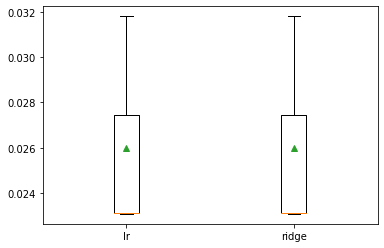

In [46]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

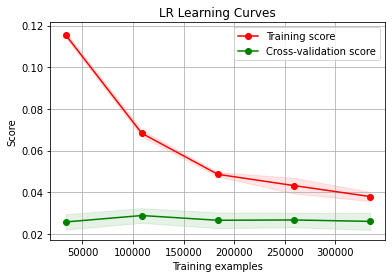

In [47]:
%%time
evaluation.plot_learning_curve(estimator=models['lr'].model,
                               title=models['lr'].name.upper()+' Learning Curves',
                               X=df_training[features], 
                               y=df_training[target],
                               cv=grp,
                               scoring=scorer)

In [ ]:

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp, 
                                   pipeline=None)

Qtde. eras: 22
performance over time


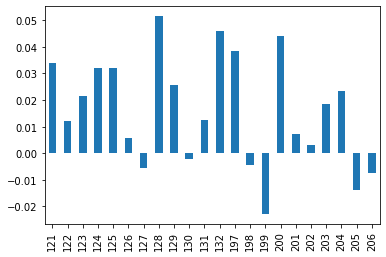

In [21]:
era_idx = [np.where(df_training.era==uera)[0] for uera in df_training.era.unique()]
def numerai_score(y_true, y_pred):
    
    
    
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return numpy.corrcoef(y_true, rank_pred)[0,1]

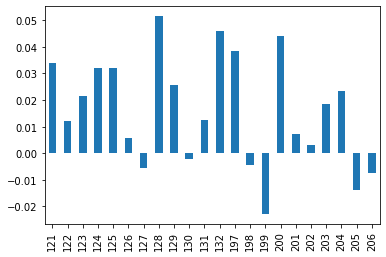

In [29]:
era_scores.plot(kind="bar")

In [27]:
feat_corrs.describe()

count    310.0000
mean       0.1034
std        0.0533
min       -0.0752
25%        0.0715
50%        0.1135
75%        0.1389
max        0.2049
dtype: float64

In [80]:
df_validation.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n0003aa52cab36c2,121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


##### Metricas regressao (melhorar para o SP)

In [17]:
model = list(filter(lambda x: x[1] == 'lr', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

# Evaluate the model
print('Model performance on validation set:')
score = model.model.score(df_validation[features], df_validation[target])  #default deve ser o R2
mse = mean_squared_error(df_validation[target], preds)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

Model performance on validation set:
Training R^2: -0.010808492754463828
Training MSE: 0.12618499994277954


Qtde. eras: 22
performance over time


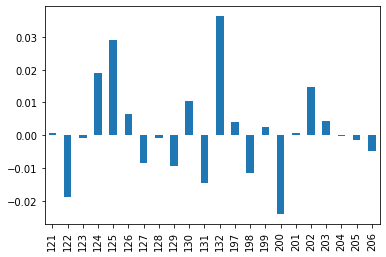

In [115]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

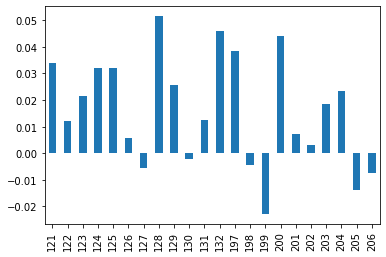

In [28]:
era_scores.plot(kind="bar")

In [116]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,rf,Submission,NA,Nome do Modelo
Max_Drawdown,-0.02401,Financeira,[0%..2%],Perda máxima em uma era
Validation_Corr,0.001461,Submission,"[3.6%..4.4%] 4.8%, overfitting",Média spearman corr por era
Median_corr,0.0001883,Estatistica,[3.6%..4.4%] Dentro do range de médias,Mediana spearman corr por era
Variance,0.0001974,Estatistica,[0..] Próximo a zero,Variancia spearman corr por era
Std_Dev,0.01405,Estatistica,[0..] Próximo a zero,Std spearman corr por era
AR(1),-0.02083,Estatistica,[0..] Próximo a zero,AR(1) pearson corr eras[:-1] e eras[1:]
Skewness,0.6107,Estatistica,[0..1],"Skewness, central moment **3"
Exc_Kurtosis,0.374,Estatistica,[-1..0],Kurtosis central moment **4


### 5a Parte treino 120 eras

### 6a Pate meta model

### Rascunho

In [28]:
memory_usage.memory()

Available memory (%): 13.227272033691406


In [7]:
results, res_cv = list(), dict()

In [6]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

In [ ]:
rf_param_grid =  {
    'reg_rf__n_estimators' : [10],
}


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'reg_rf',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

In [ ]:
result[0].results

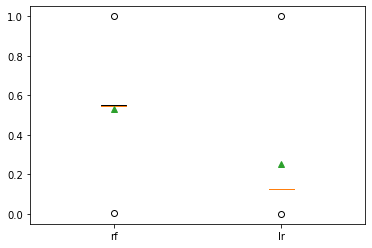

In [10]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [13]:
#carregando o modelo
model_loaded = load(file_path)

>cores=1: 22.561 seconds
>cores=2: 13.700 seconds
>cores=3: 9.732 seconds
>cores=4: 9.550 seconds
>cores=5: 8.731 seconds
>cores=6: 8.896 seconds
>cores=7: 9.042 seconds
>cores=8: 9.022 seconds


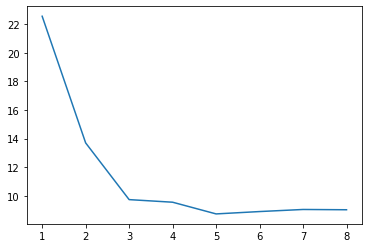

In [35]:
# example of comparing number of cores used during training to execution speed
from time import time
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
results = list()
# compare timing for number of cores
n_cores = [1, 2, 3, 4, 5, 6, 7, 8]
for n in n_cores:
	# capture current time
	start = time()
	# define the model
	model = RandomForestClassifier(n_estimators=500, n_jobs=n)
	# fit the model
	model.fit(X, y)
	# capture current time
	end = time()
	# store execution time
	result = end - start
	print('>cores=%d: %.3f seconds' % (n, result))
	results.append(result)
pyplot.plot(n_cores, results)
pyplot.show()

In [7]:
load_baseline = pd.read_csv("../../reports/results_baseline.csv")
load_baseline

,outsample,insample,time_elapsed_GPU(s),time_elapsed(s)
LGBMRegressor,0.0447,0.2677,23.8324,62.3275
XGBRanker,0.0442,0.2021,67.5707,469.0444
XGBRegressor,0.0440,0.2667,37.2466,445.6100
LGBMClassifier,0.0305,0.2070,137.1966,301.8254
XGBClassifier,0.0302,0.1648,232.9470,2172.2911
CatBoostClassifier,0.0271,0.0959,19.0138,1193.6433
CatBoostRegressor,0.0267,0.0949,9.2403,209.8839
LGBMRanker,0.0150,0.0647,6092.7200,16133.8554


In [ ]:
df_nomi = pd.read_csv("../../data/raw/numerai_datasets/numerai_training_validation_target_nomi.csv")